In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## locate sessions with mec and pfc

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)


In [38]:
# cell_metrics.brainRegion.value_counts()


In [4]:
mec_sessions = pd.DataFrame()
mec_sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

mec_sessions.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\mec_sessions.csv")

pfc_sessions = pd.DataFrame()
pfc_sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC")
].basepath.unique()
pfc_sessions.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pfc_sessions.csv")


## make psth on ripple for ca1, pfc, and mec

In [43]:
sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

sessions


,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day27
3,Z:\Data\AYAold\AYA9\day12
4,Z:\Data\AYAold\AYA9\day15
...,...
94,Z:\Data\ORproject\OR18\day3
95,Z:\Data\HMC1\day8
96,Z:\Data\HMC1\day10
97,Z:\Data\AYAold\AYA9\day14


In [64]:
psth_df = pd.DataFrame()
cell_metrics = pd.DataFrame()
for basepath in sessions.basepath:

    st, cell_metric = loading.load_spikes(basepath)
    ripples = loading.load_ripples_events(basepath)
    replays_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T])

    psth = functions.compute_psth(
        st.data, replays_epochs.starts, bin_width=0.01, n_bins=100
    )
    psth_df = pd.concat([psth_df, psth], axis=1, ignore_index=True)
    cell_metrics = pd.concat([cell_metrics, cell_metric], axis=0, ignore_index=True)


In [124]:
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)

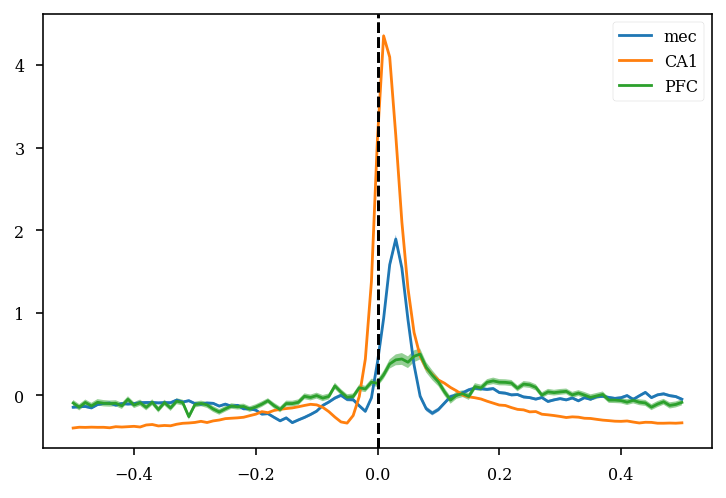

In [132]:
def plot_psth_mean(psth_df,cell_metrics, region_idx, label):


    psth = psth_df.values[:,cell_metrics.brainRegion.str.contains(region_idx).values]

    psth_z = stats.zscore(psth, axis=0)
    plt.plot(psth_df.index, np.nanmean(psth_z, axis=1), label=label)
    plt.fill_between(
        psth_df.index,
        np.nanmean(psth_z, axis=1) - np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        np.nanmean(psth_z, axis=1) + np.nanstd(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        alpha=0.5,
    )
    plt.axvline(x=0, color="k", linestyle="--")
    plt.legend()

plot_psth_mean(psth_df,cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
plot_psth_mean(psth_df,cell_metrics, "CA1", "CA1")
plot_psth_mean(psth_df,cell_metrics, "PFC", "PFC")

# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values].mean(axis=1),label="mec")
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("CA1").values].mean(axis=1),label='ca1')
# plt.plot(psth_df.index, psth_df.values[:,cell_metrics.brainRegion.str.contains("PFC").values].mean(axis=1),label='pfc')
# plt.axvline(x=0, color="k", linestyle="--")
plt.legend()
plt.show()

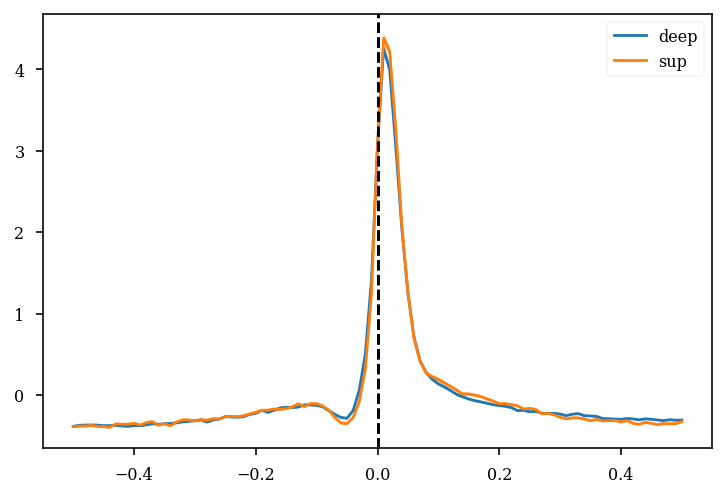

In [138]:
plot_psth_mean(psth_df.loc[:,cell_metrics.deepSuperficial.str.contains("Deep")],cell_metrics[cell_metrics.deepSuperficial.str.contains("Deep")], "CA1", "deep")
plot_psth_mean(psth_df.loc[:,cell_metrics.deepSuperficial.str.contains("Superficial")],cell_metrics[cell_metrics.deepSuperficial.str.contains("Superficial")], "CA1", "sup")


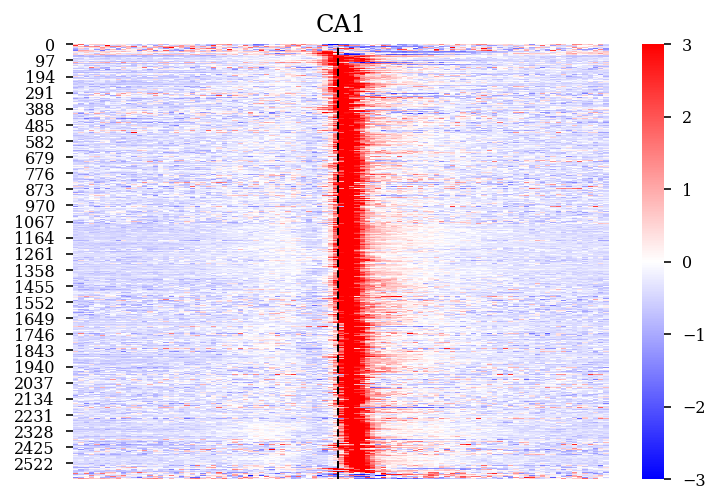

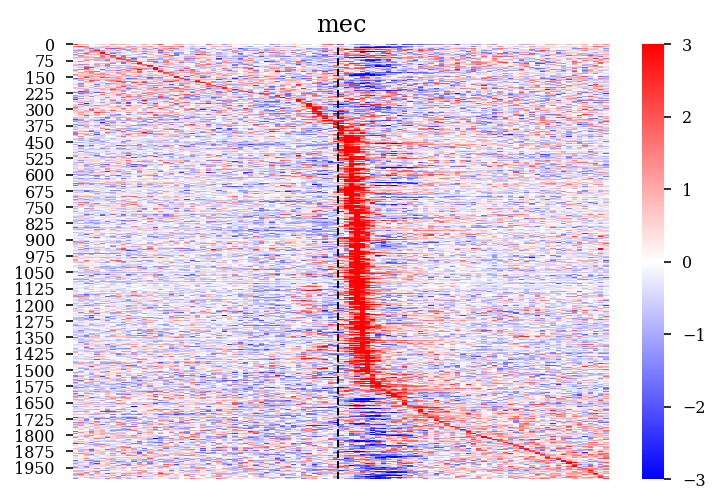

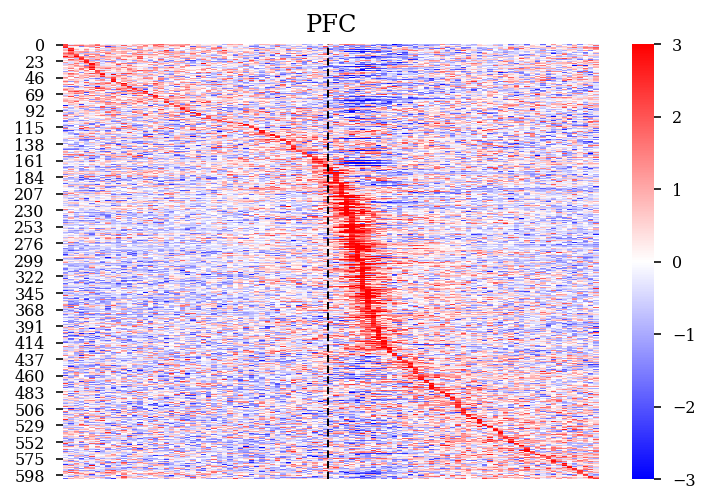

In [123]:
def plot_psth_matrix(psth_df, cell_metrics, region_idx, label):


    psth = psth_df.values[:,cell_metrics.brainRegion.str.contains(region_idx).values]

    sort_idx = np.argsort(np.argmax(psth, axis=0))
    plt.figure()
    ax = plt.gca()
    sns.heatmap(
        stats.zscore(psth, axis=0)[:,sort_idx].T,
        ax=ax,
        cmap="bwr",
        vmax=3,
        vmin=-3,
        xticklabels=False,
    )
    ax.axvline(50, color="k", lw=1, ls="--")
    ax.set_title(label,fontsize=12)
    
plot_psth_matrix(psth_df,cell_metrics, "CA1", "CA1")
plot_psth_matrix(psth_df,cell_metrics, "EC1|EC2|EC3|EC4|EC5|MEC", "mec")
plot_psth_matrix(psth_df,cell_metrics, "PFC", "PFC")

# plot_psth_matrix(psth_df,cell_metrics, region_idx, label)


In [10]:
basepath = r"Z:\Data\HMC1\day8"
# mec_sessions

In [209]:
# for basepath in mec_sessions.basepath:

st, cell_metric = loading.load_spikes(basepath,brainRegion=["CA1","PFC","MEC"])
ripples = loading.load_ripples_events(basepath)
ripple_epochs = nel.EpochArray([np.array([ripples.start, ripples.stop]).T]).expand(0.1,direction="stop")

# unit_mat = functions.get_participation(st.data,ripple_epochs.starts, ripple_epochs.stops)

In [410]:
# st[ripple_epochs][:,ca1_idx]
from nelpy.utils import get_mua
deepSuperficialDistance = cell_metric[cell_metric.brainRegion.str.contains("CA1")].deepSuperficialDistance.values
deepSuperficialDistance

bins = np.arange(-200,250,50)
ca1_idx = (np.where(cell_metric.brainRegion.str.contains("CA1").values & (cell_metric.deepSuperficialDistance > bins[1]) & (cell_metric.deepSuperficialDistance < bins[2]))[0]+1).astype(int)
spks = st[ripple_epochs][:,ca1_idx].copy()
# st[:,pfc_idx].data
mua = get_mua(spks)
# mua_binned = st.bin(ds=ds).flatten()
# crosscorrs, c = functions.pairwise_cross_corr(spks, binsize=0.001, nbins=100, return_index=True)

In [417]:
pfc_idx = (np.where(cell_metric.brainRegion.str.contains("PFC").values)[0]+1).astype(int)
# pfc_spks = st[ripple_epochs][:,pfc_idx].copy()

mua_pfc = get_mua(st[ripple_epochs][:,pfc_idx])


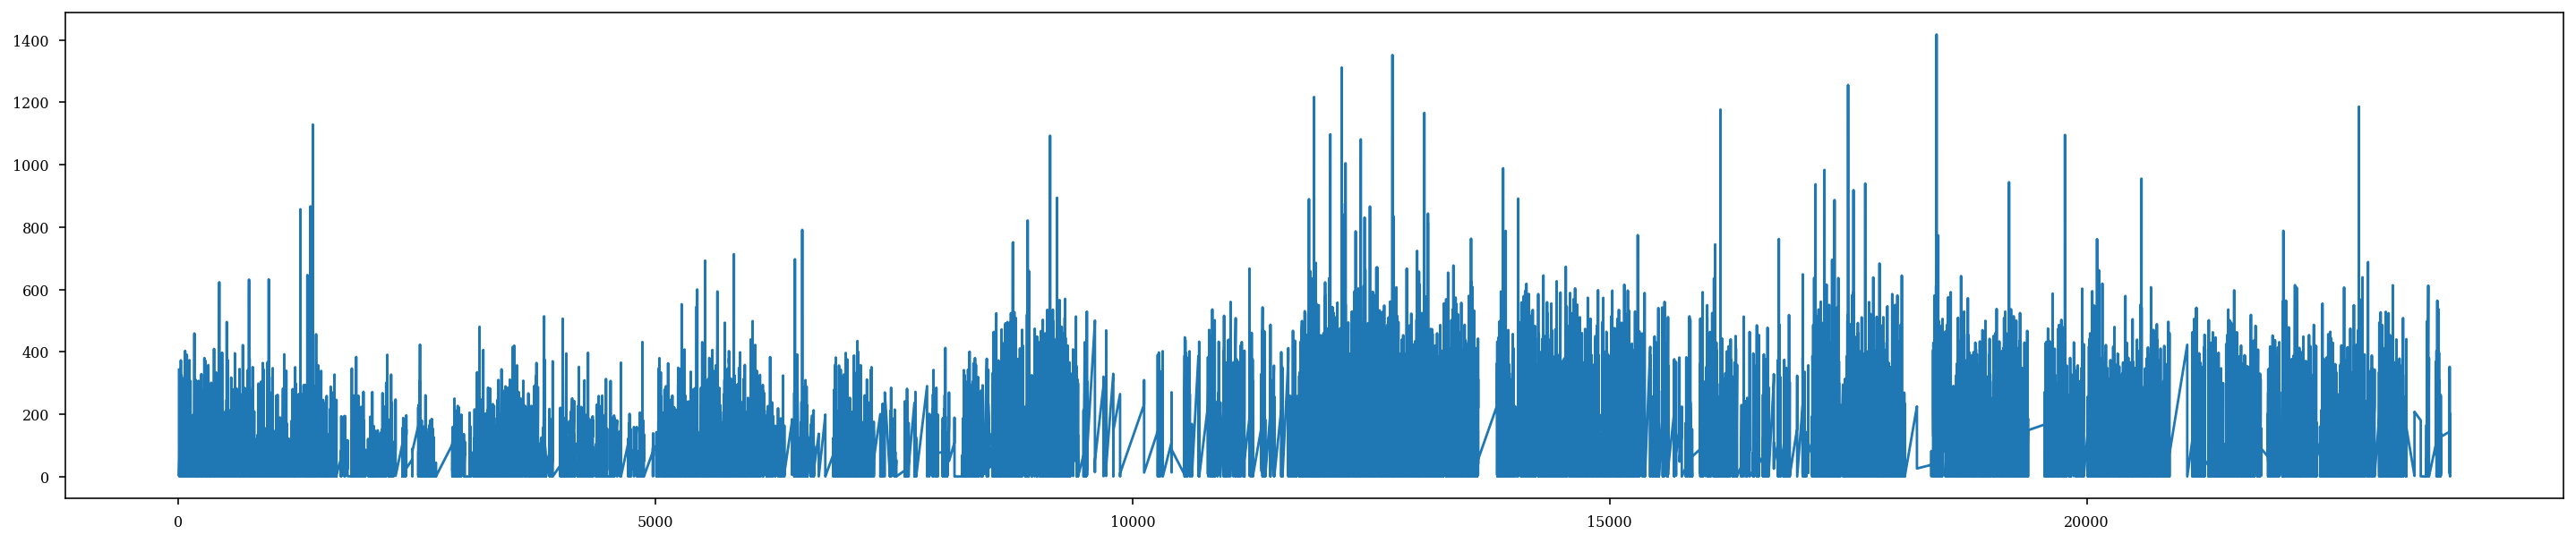

In [416]:
plt.figure(figsize=(25,5))

plt.plot(mua.abscissa_vals,mua.data.T)
plt.show()

In [210]:
# cell_metric.brainRegion.str.contains("CA1").values
ca1_idx = (np.where(cell_metric.brainRegion.str.contains("CA1").values)[0]+1).astype(int)

ca1_unit_mat = functions.get_participation(st[:,ca1_idx].data,ripple_epochs.starts, ripple_epochs.stops)


In [211]:
pfc_idx = (np.where(cell_metric.brainRegion.str.contains("PFC").values)[0]+1).astype(int)

pfc_unit_mat = functions.get_participation(st[:,pfc_idx].data,ripple_epochs.starts, ripple_epochs.stops)


In [253]:
mec_idx = (np.where(cell_metric.brainRegion.str.contains("MEC").values)[0]+1).astype(int)

mec_unit_mat = functions.get_participation(st[:,mec_idx].data,ripple_epochs.starts, ripple_epochs.stops)


<AxesSubplot:>

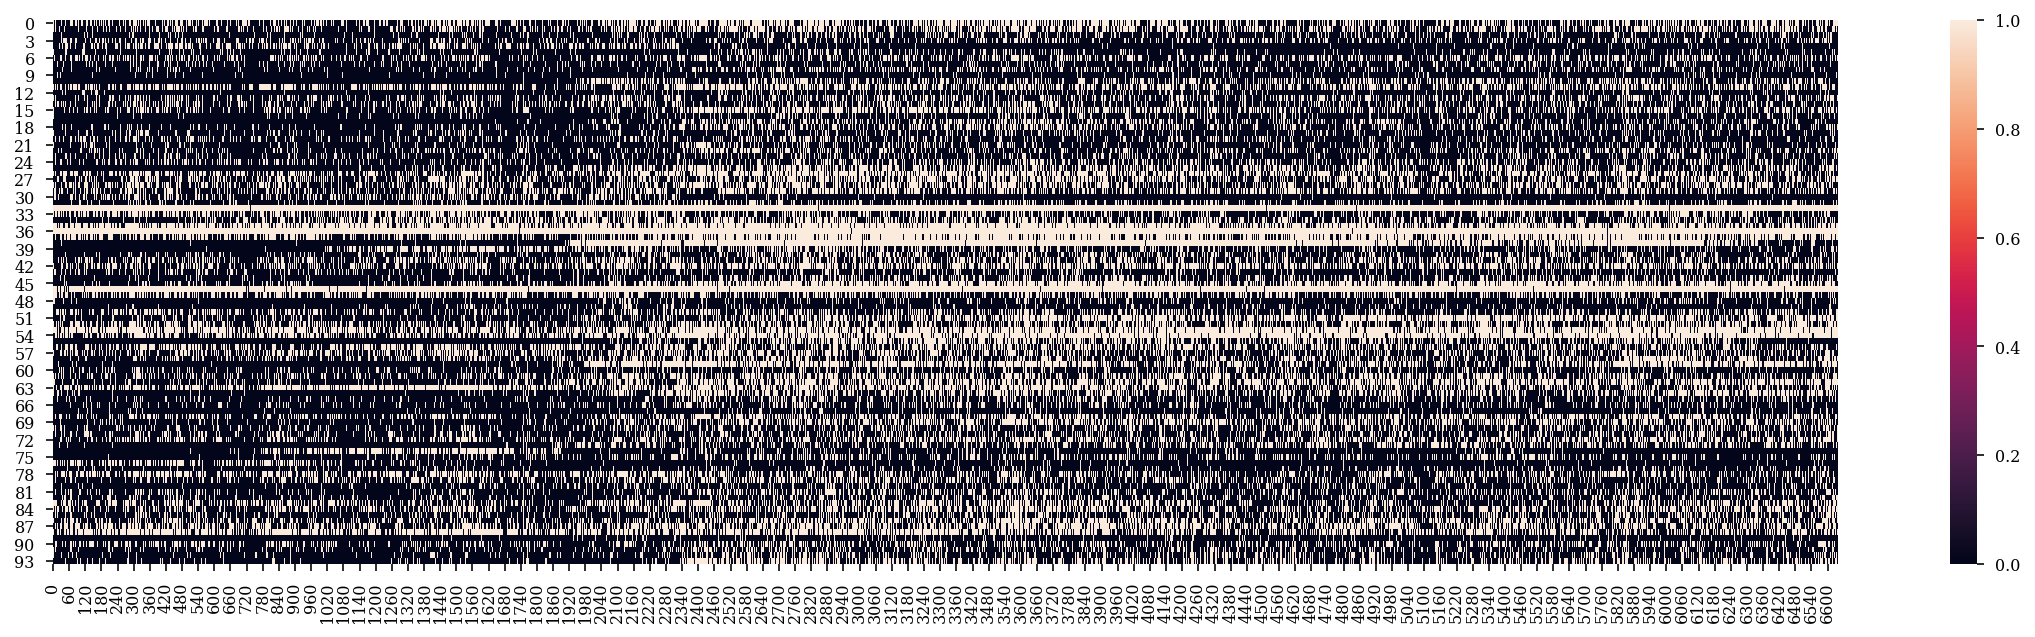

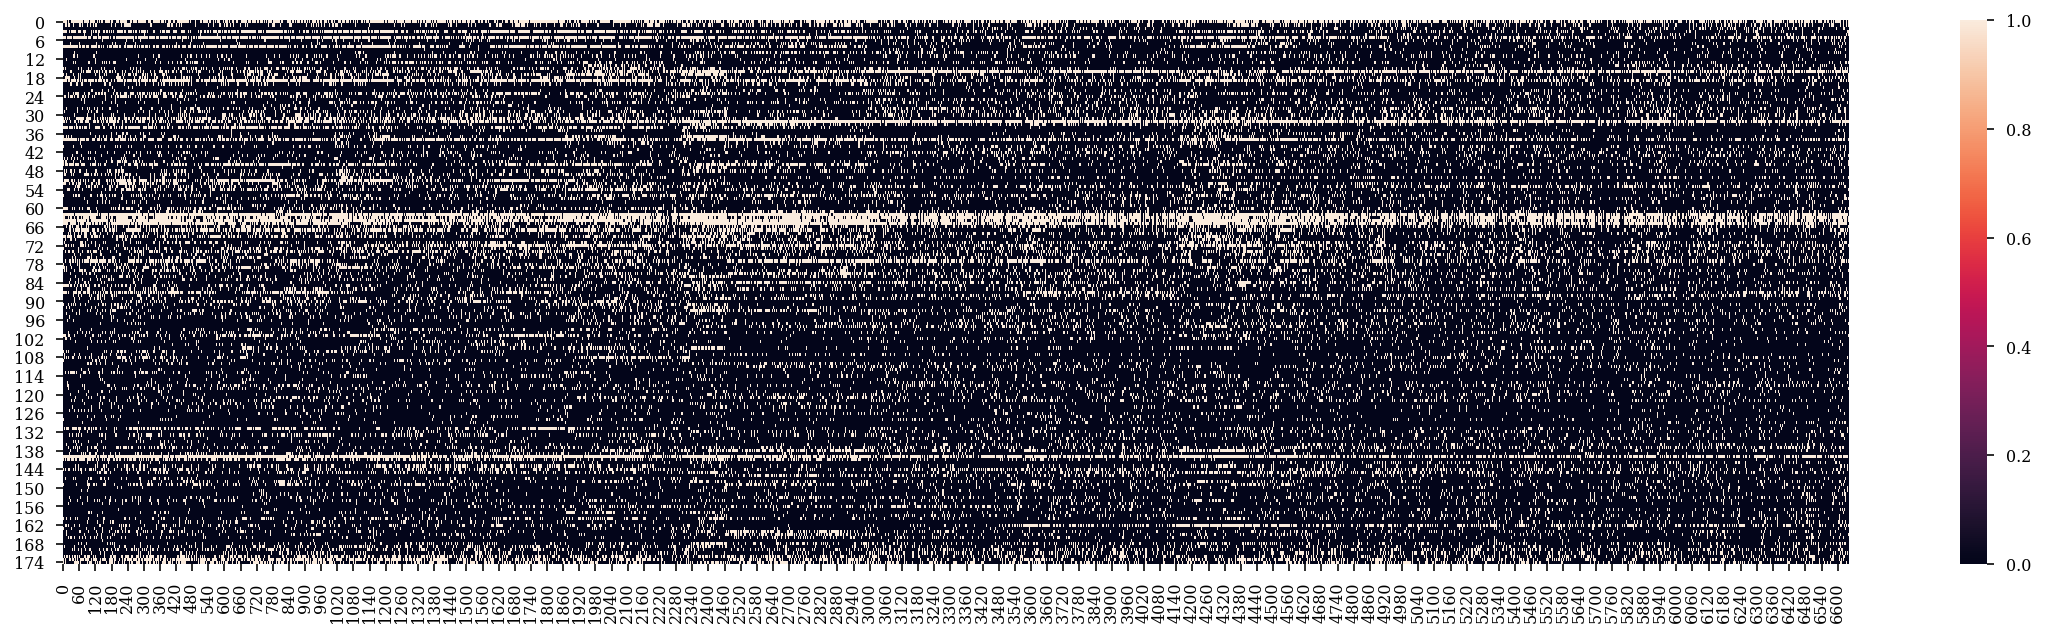

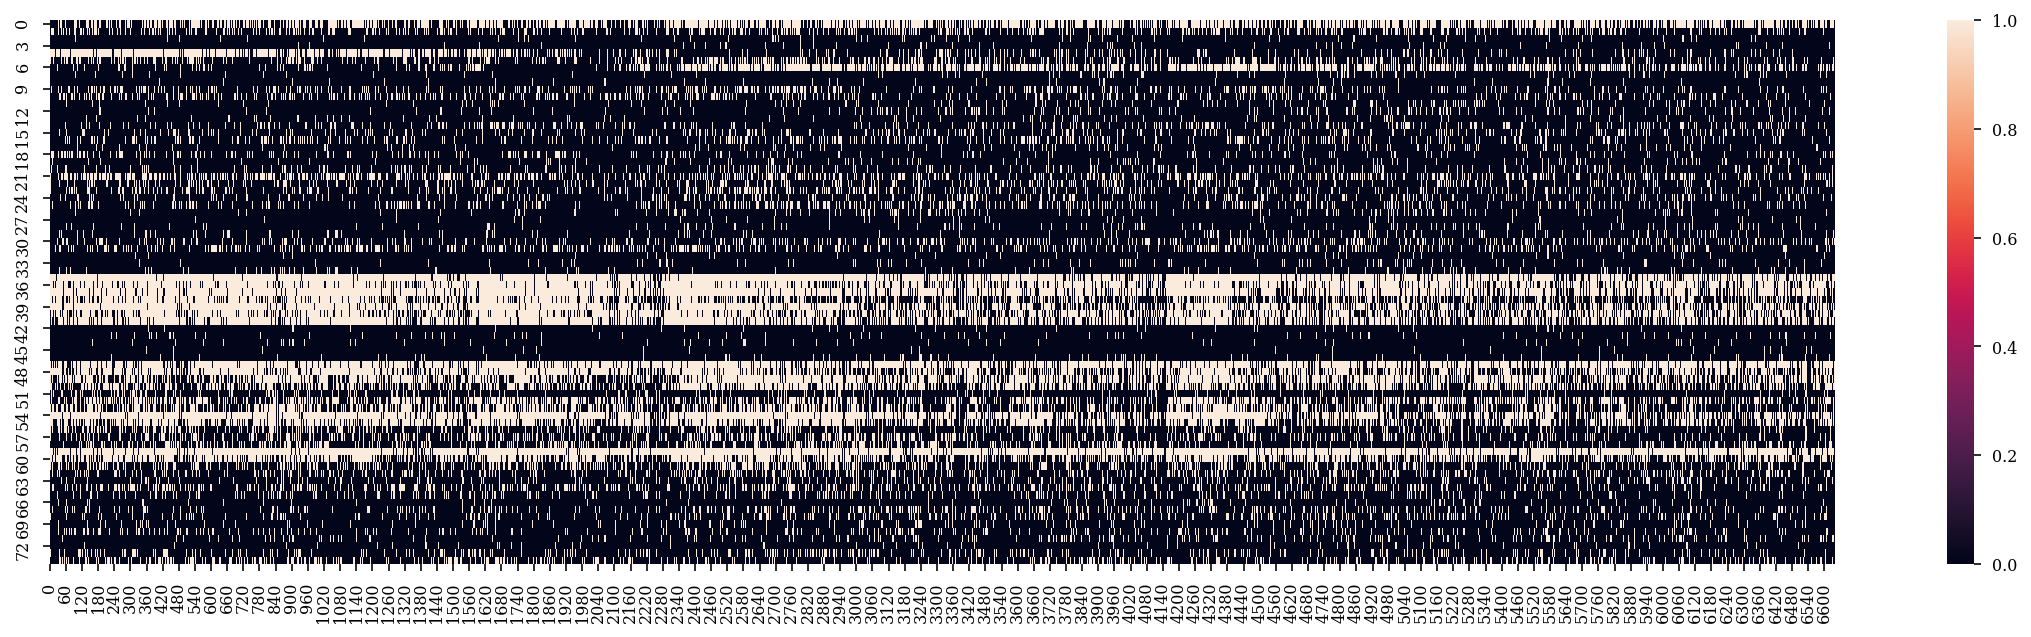

In [254]:
plt.figure(figsize=(20,5))
sns.heatmap(ca1_unit_mat)

plt.figure(figsize=(20,5))
sns.heatmap(pfc_unit_mat)

plt.figure(figsize=(20,5))
sns.heatmap(mec_unit_mat)

<Figure size 1800x360 with 0 Axes>

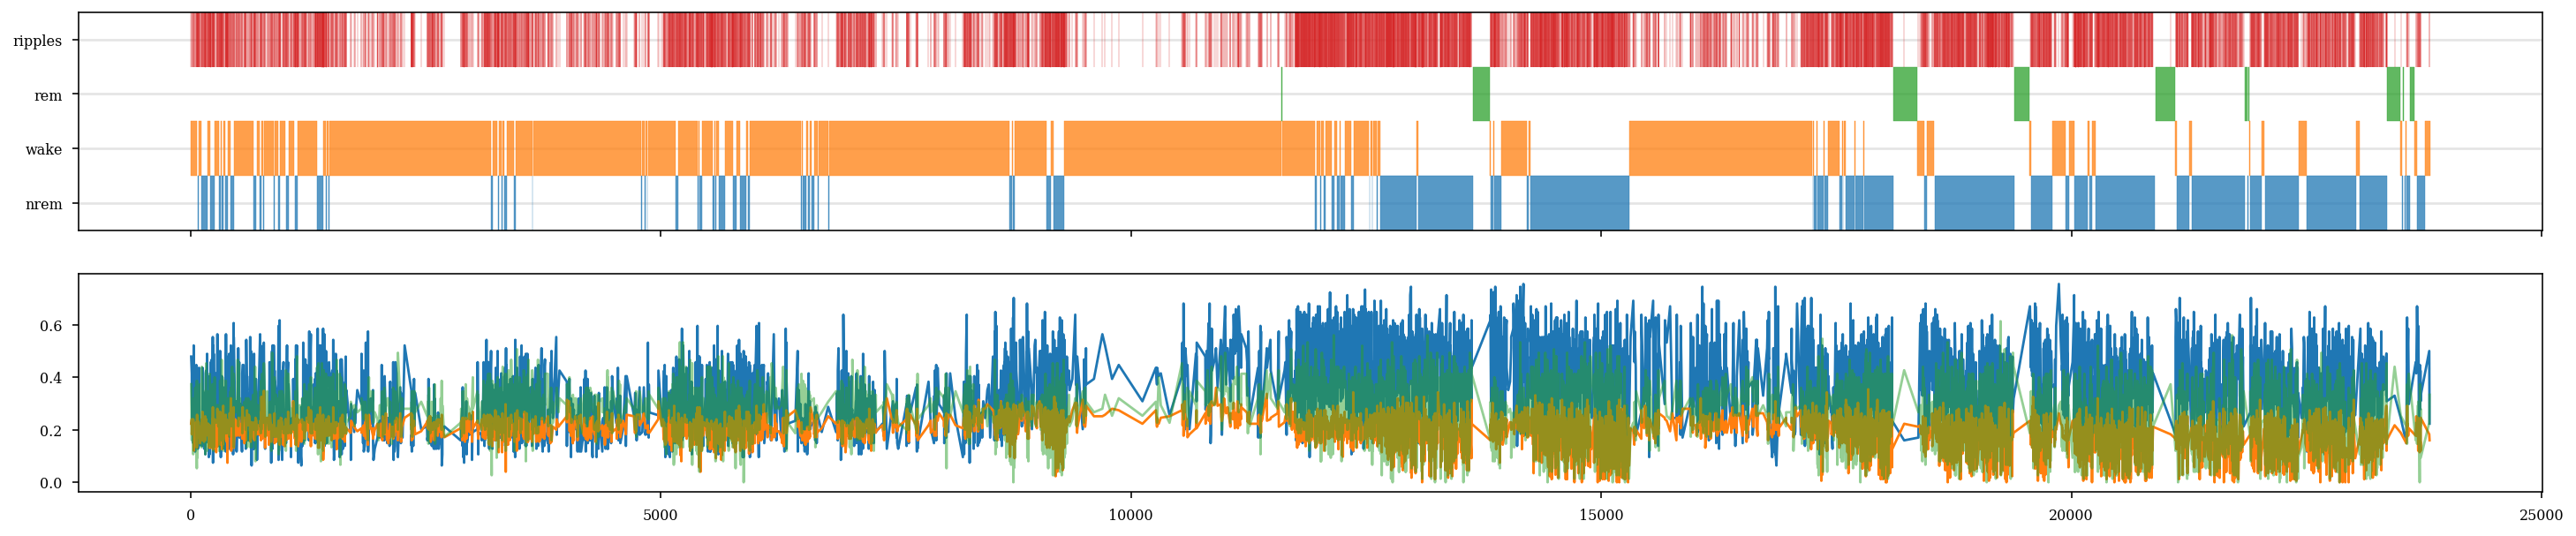

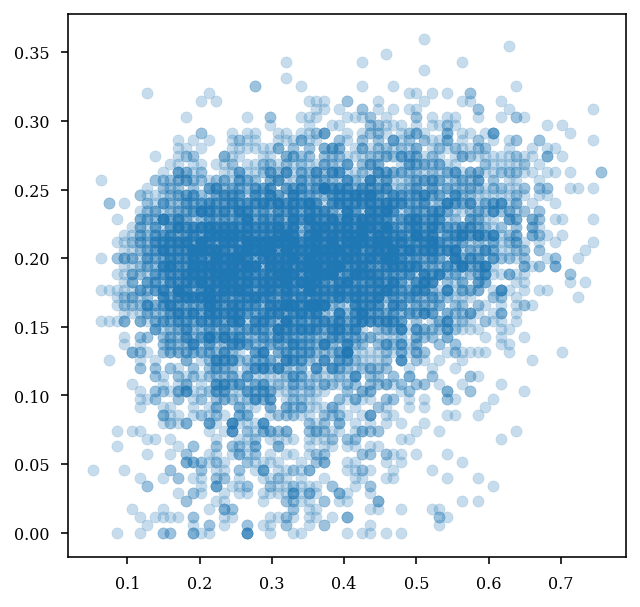

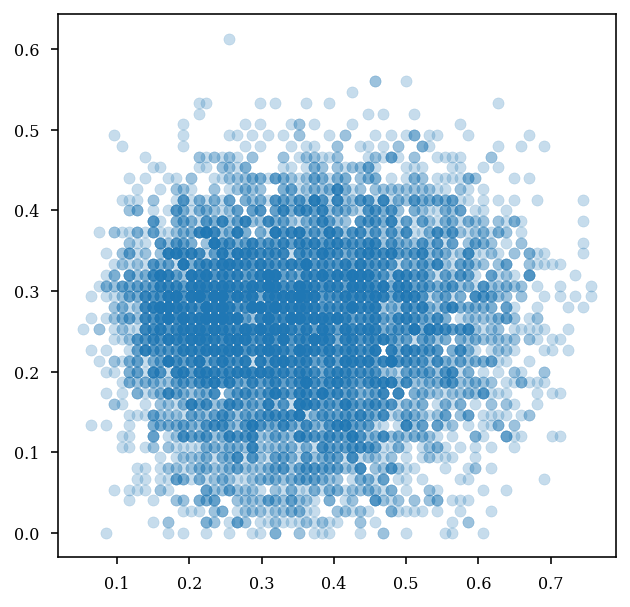

In [259]:
from ripple_heterogeneity.utils import custom_plots
plt.figure(figsize=(25,5))
# load sleep states
state_dict = loading.load_SleepState_states(basepath)

# make nelpy epoch arrays
nrem_epochs = nel.EpochArray(state_dict['NREMstate'])
wake_epochs = nel.EpochArray(state_dict['WAKEstate'])
rem_epochs = nel.EpochArray(state_dict['REMstate'])

# add to list
events = []
events.append(nrem_epochs)
events.append(wake_epochs)
events.append(rem_epochs)
events.append(ripple_epochs)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(25,5), sharex=True)

custom_plots.plot_events(events,['nrem','wake','rem','ripples'],ax=ax1)

ax2.plot(ripple_epochs.starts, ca1_unit_mat.mean(axis=0))
ax2.plot(ripple_epochs.starts, pfc_unit_mat.mean(axis=0))
ax2.plot(ripple_epochs.starts, mec_unit_mat.mean(axis=0),alpha=.5)

plt.figure(figsize=(5,5))
plt.scatter(ca1_unit_mat.mean(axis=0), pfc_unit_mat.mean(axis=0),alpha=.25)

plt.figure(figsize=(5,5))
plt.scatter(ca1_unit_mat.mean(axis=0), mec_unit_mat.mean(axis=0),alpha=.25)

In [319]:
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process
from elephant.spike_train_synchrony import spike_contrast
from viziphant.rasterplot import rasterplot
from viziphant.rasterplot import eventplot
import viziphant
spiketrain_1 = homogeneous_poisson_process(rate=20*pq.Hz,
    t_stop=1000*pq.ms)
spiketrain_2 = homogeneous_poisson_process(rate=20*pq.Hz,
    t_stop=1000*pq.ms)
spiketrain_3 = homogeneous_poisson_process(rate=20*pq.Hz,
    t_stop=1000*pq.ms)

spike_contrast([spiketrain_1, spiketrain_2, spiketrain_3])

0.2917437557816836

In [357]:
from quantities import s
from neo.core import SpikeTrain
train = []
for spk in st.data[0:10]:
    train.append(SpikeTrain(spk, t_start=st.first_event, t_stop=st.last_event,units='s'))

In [355]:
# train

<AxesSubplot:xlabel='Time (s)'>

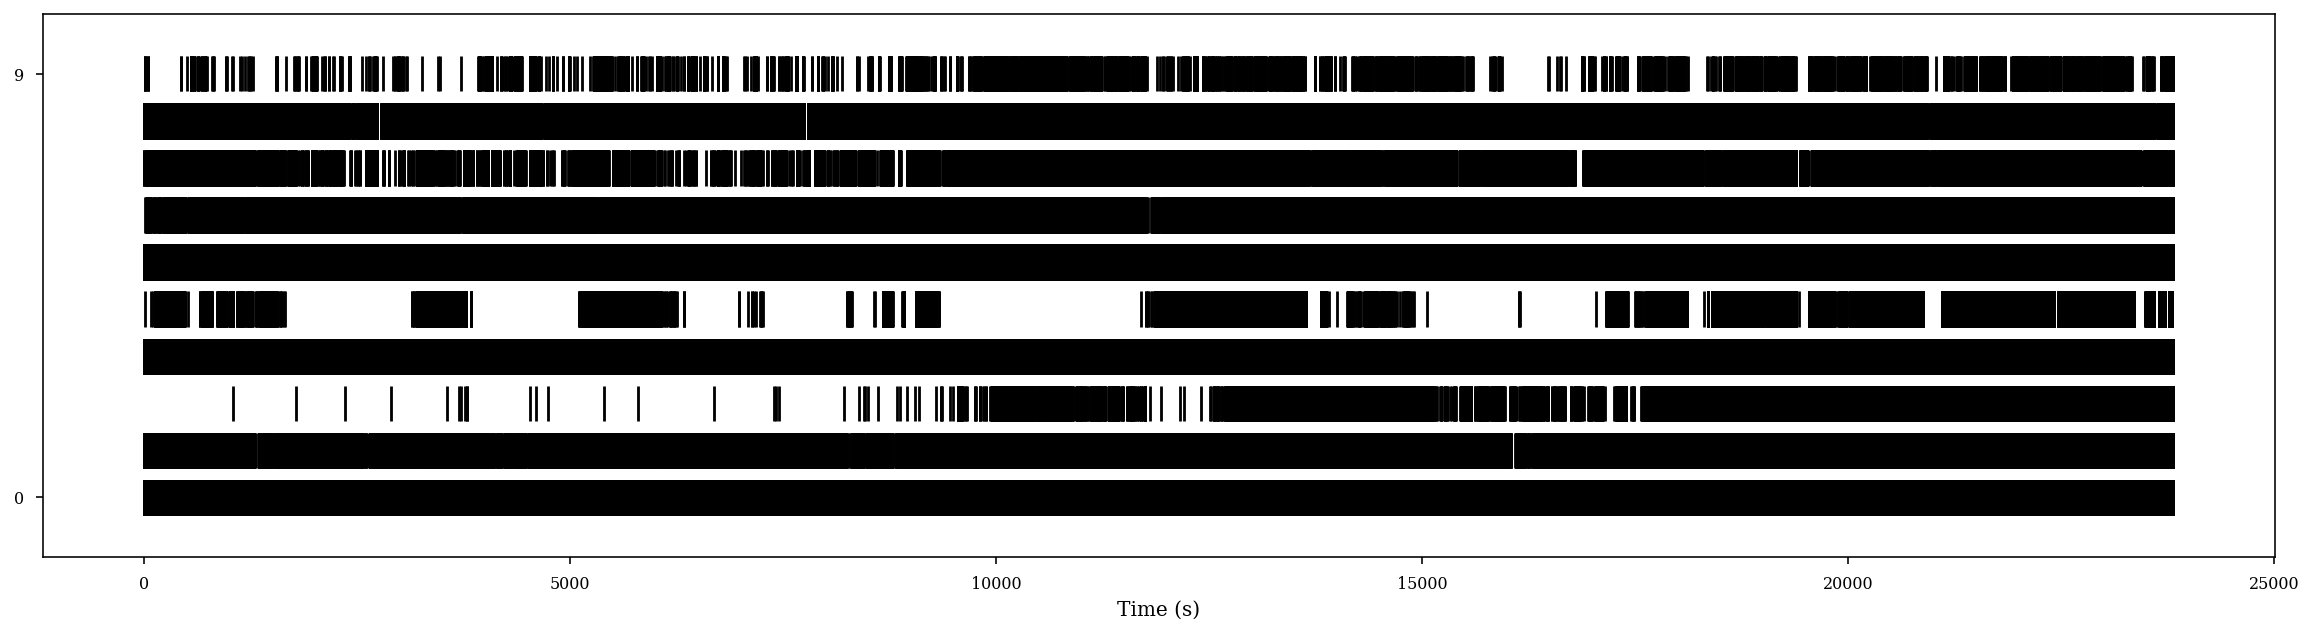

In [358]:
plt.figure(figsize=(20,5))
ax = plt.gca()
eventplot(train, linelengths=0.75, color='black',axes=ax)


array([<AxesSubplot:title={'center':'Spike-contrast synchrony measure'}, xlabel='Bin size $\\Delta$ (s)'>,
       <AxesSubplot:xlabel='Time (s)', ylabel='neuron'>], dtype=object)

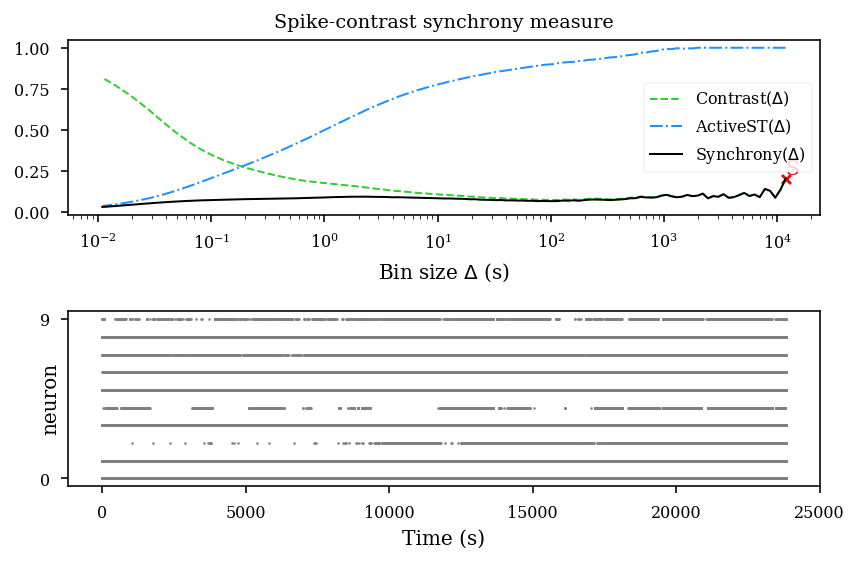

In [361]:
synchrony, trace = spike_contrast(train, return_trace=True)
viziphant.spike_train_synchrony.plot_spike_contrast(trace,
     spiketrains=train, c='gray', s=1)


array([<AxesSubplot:title={'center':'Spike-contrast synchrony measure'}, xlabel='Bin size $\\Delta$ (s)'>,
       <AxesSubplot:xlabel='Time (s)', ylabel='neuron'>], dtype=object)

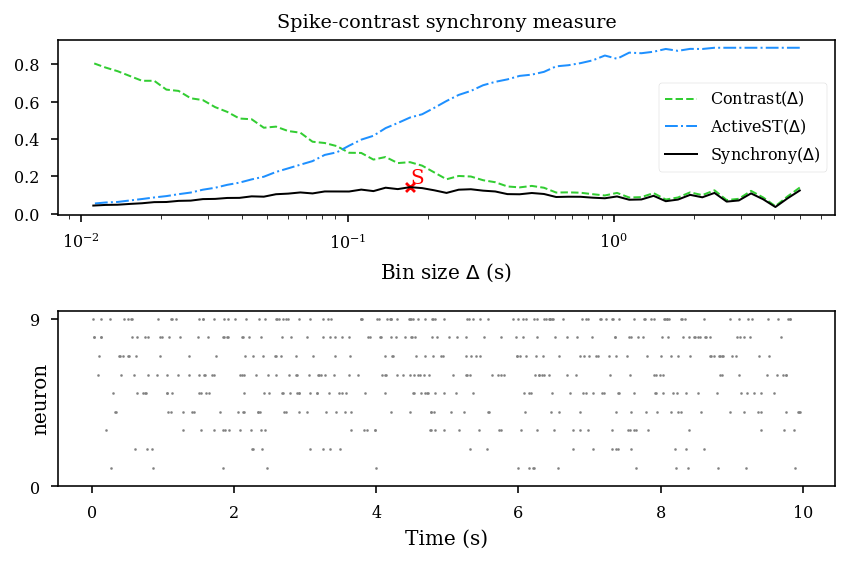

In [324]:
spiketrains = [homogeneous_poisson_process(rate=(i*pq.Hz),
               t_stop=10*pq.s) for i in range(10)]
# plt.figure(figsize=(20,5))
# ax = plt.gca()
# rasterplot(spiketrains, s=4, c='black',axes=ax,marker='|')
# eventplot(spiketrains, linelengths=0.75, color='black',axes=ax)

spike_contrast(spiketrains)

synchrony, trace = spike_contrast(spiketrains, return_trace=True)
viziphant.spike_train_synchrony.plot_spike_contrast(trace,
     spiketrains=spiketrains, c='gray', s=1)

In [281]:
spiketrain = []
for i in range(100):
    spiketrain.append(homogeneous_poisson_process(rate=20*pq.Hz,
    t_stop=1000*pq.ms)) 

# plt.eventplot(spiketrain)

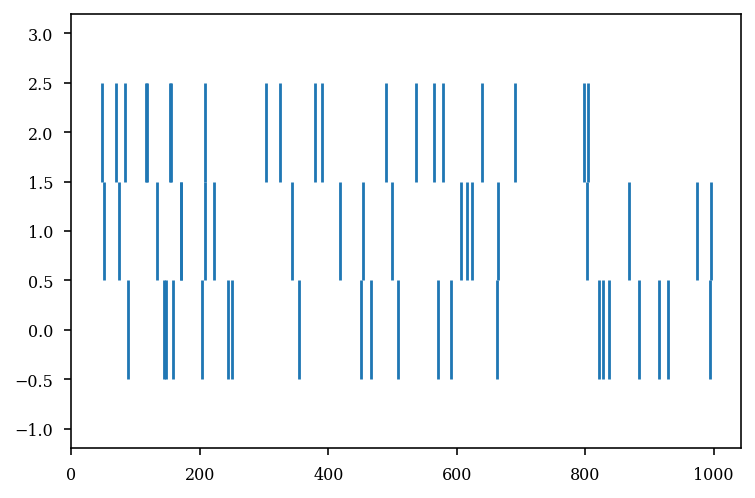

In [278]:
plt.eventplot([spiketrain_1.times, spiketrain_2.times, spiketrain_3.times])
# plt.eventplot(spiketrain_2.times,color='r')
# plt.eventplot(spiketrain_3.times,color='g')


In [372]:
X[0,0:2]

array([  5., 162.])

In [374]:
from sklearn.datasets import load_linnerud
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
X, y = load_linnerud(return_X_y=True)
regr = MultiOutputRegressor(Ridge(random_state=123)).fit(X[:,0:2], y)
regr.predict([X[0,0:2]])

array([[177.67814314,  35.50960582,  56.61100487]])

In [365]:
X.shape

(20, 3)

In [185]:
deepSuperficialDistance = cell_metric[cell_metric.brainRegion.str.contains("CA1")].deepSuperficialDistance.values

X = np.zeros_like(ca1_unit_mat) * np.nan
for i,vec in enumerate(ca1_unit_mat.T):
    X[vec == 1,i] = deepSuperficialDistance[vec == 1]

<AxesSubplot:>

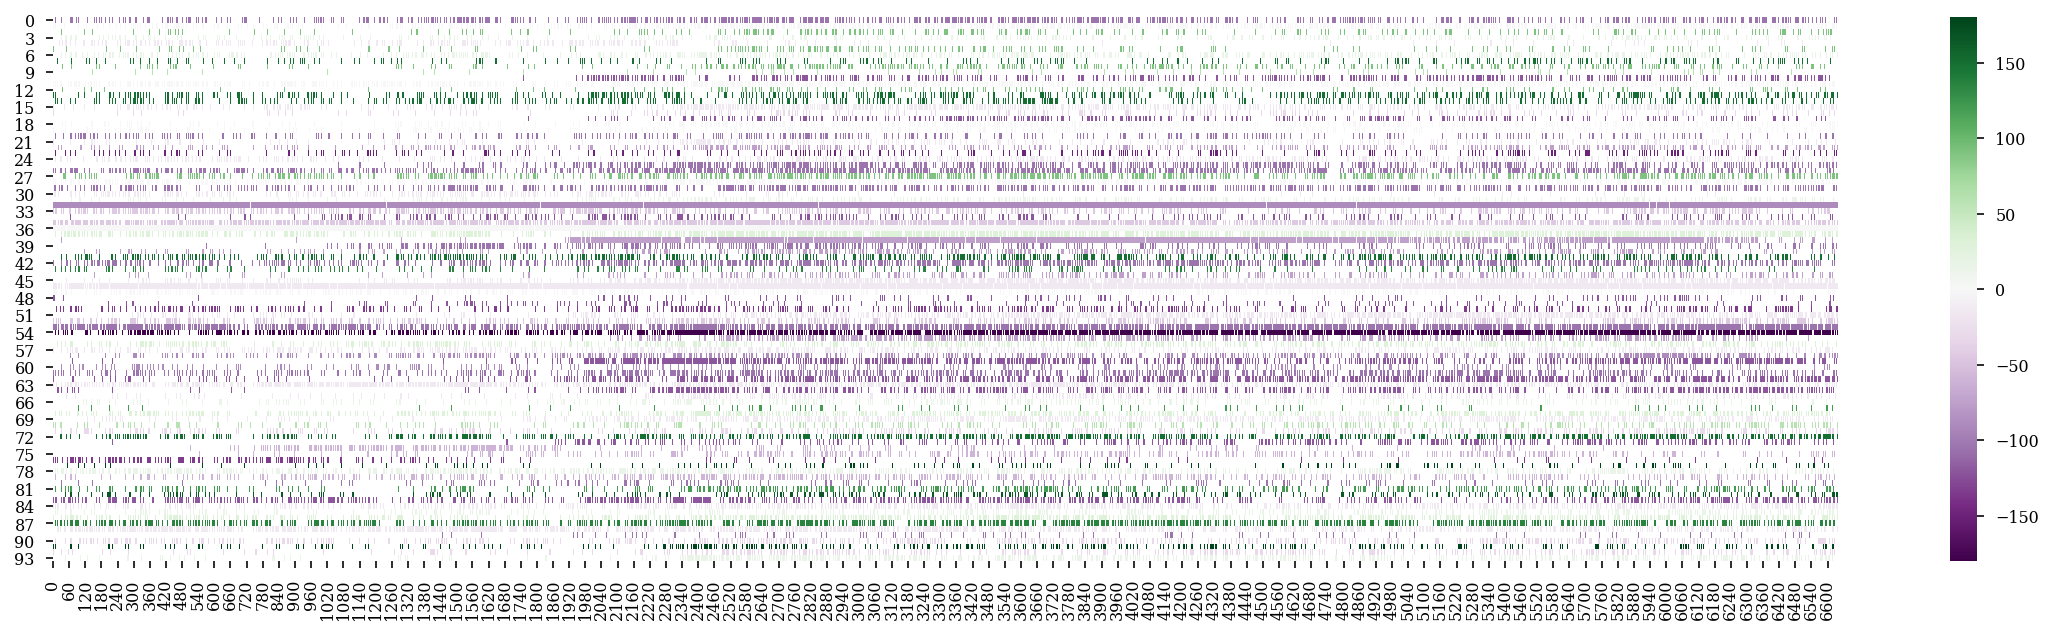

In [186]:
plt.figure(figsize=(20,5))
sns.heatmap(X,cmap="PRGn")

In [190]:
# plt.figure(figsize=(20,5))
# plt.plot(X_reduced[:,0])

In [ ]:
# from sklearn.decomposition import PCA
# X_reduced = PCA(n_components=2).fit_transform(X.T)
# plt.scatter(X_reduced[:,0],X_reduced[:,1],alpha=.5)

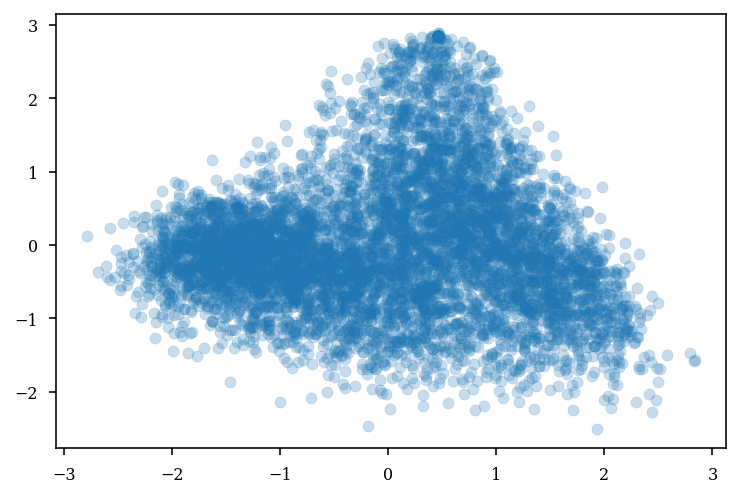

In [376]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=5).fit_transform(pfc_unit_mat.T)
plt.scatter(X_reduced[:,0],X_reduced[:,1],alpha=.25)

In [377]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
# from sklearn.impute import SimpleImputer
from sklearn import preprocessing

# y = np.expand_dims(X_reduced[:,0:1],axis=1)
y = X_reduced[:,0]
X = ca1_unit_mat.T
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)

extra_tree = ExtraTreeRegressor(random_state=0)
reg = BaggingRegressor(extra_tree, random_state=0).fit(
    X_train_transformed, y_train)

X_test_transformed = scaler.transform(X_test)
reg.score(X_test_transformed, y_test)


0.4672656077160633

In [378]:
from sklearn.pipeline import make_pipeline
reg = make_pipeline(preprocessing.StandardScaler(), BaggingRegressor(extra_tree, random_state=0))

scores = cross_val_score(reg, X, y, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


[-0.64997265 -0.59677116 -0.2577023  -0.01413381 -0.83271565]
-0.47 accuracy with a standard deviation of 0.29


In [379]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.47 accuracy with a standard deviation of 0.29


In [ ]:
reg['baggingregressor'].predict(X_test)

In [ ]:
ax = plt.gca()

ax.scatter(y_test[:,0],reg.BaggingRegressor.predict(X_test)[:,0],alpha=.25)
ax.scatter(y_test[:,1],reg.predict(X_test)[:,1],alpha=.25)
# ax.set_aspect('equal', 'box')

# ax.set_aspect('equal', adjustable='box')
# ax.axis('scaled')
# plt.axis('square')

In [39]:
replays_df = pd.read_csv(
    r"Z:\home\ryanh\projects\ripple_heterogeneity\layer_bias_replays.csv"
)
replays_df.keys()


Index(['Unnamed: 0', 'start', 'stop', 'peaks', 'amplitude', 'duration',
       'frequency', 'detectorName', 'ripple_channel', 'event_spk_thres',
       'basepath', 'basename', 'animal', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'traj_dist',
       'traj_speed', 'traj_step', 'replay_type', 'pop_partic', 'decoding_r2',
       'decoding_r2_pval', 'decoding_median_error', 'total_units', 'direction',
       'n_replays', 'sig_unit_bias', 'n_deep_obs', 'n_sup_obs', 'n_middle_obs',
       'pval_deep', 'pval_sup', 'pval_middle', 'event_id', 'balance',
       'effective', 'equal', 'ins', 'isns', 'gmm_labels', 'constant'],
      dtype='object')

In [4]:
replays_df.sig_unit_bias.value_counts()


unknown    76503
deep        2658
middle      2388
sup         2118
Name: sig_unit_bias, dtype: int64

In [ ]:
# st,cell_metrics = loading.load_spikes("Z:\Data\HMC1\day8",putativeCellType="Pyr")

# or18 has pfc cells


In [18]:
basepaths = ["Z:\Data\HMC1\day8", "Z:\Data\HMC1\day9", "Z:\Data\HMC1\day10"]
df_hmc1 = pd.DataFrame()
for basepath in basepaths:
    st, cell_metrics = loading.load_spikes(basepath, putativeCellType="Pyr")

    # replays_df = df[(df.basepath == basepath) & (df.score_pval_time_swap < 0.05)]
    replays_df_temp = df[(df.basepath == basepath)]

    replays_epochs = nel.EpochArray([np.array([replays_df.start, replays_df.stop]).T])
    replays_epochs.expand(0.1, direction="stop")

    ca1_idx = np.where(cell_metrics.brainRegion.str.contains("CA1"))[0] + 1
    pfc_idx = np.where(cell_metrics.brainRegion.str.contains("PFC"))[0] + 1
    mec_idx = np.where(cell_metrics.brainRegion.str.contains("MEC"))[0] + 1

    pfc_spikes = []
    ca1_spikes = []
    mec_spikes = []

    st_eps = st[replays_epochs]
    for st_ep in st_eps:
        ca1_spikes.append(np.sum(st_ep[:, ca1_idx].n_events))
        pfc_spikes.append(np.sum(st_ep[:, pfc_idx].n_events))
        mec_spikes.append(np.sum(st_ep[:, mec_idx].n_events))

    replays_df_temp["ca1_spikes"] = ca1_spikes
    replays_df_temp["pfc_spikes"] = pfc_spikes
    replays_df_temp["mec_spikes"] = mec_spikes

    df_hmc1 = pd.concat([df_hmc1, replays_df_temp], ignore_index=True)


In [275]:
replays_df = df[(df.basepath == basepath) & (df.score_pval_time_swap < 0.05)]

replays_epochs = nel.EpochArray([np.array([replays_df.start, replays_df.stop]).T])
replays_epochs.expand(0.1, direction="stop")


<EpochArray at 0x1a470383ac0: 132 epochs> of length 25.20959999999999998 seconds

In [254]:
ca1_idx = np.where(cell_metrics.brainRegion.str.contains("CA1"))[0] + 1
pfc_idx = np.where(cell_metrics.brainRegion.str.contains("PFC"))[0] + 1
mec_idx = np.where(cell_metrics.brainRegion.str.contains("MEC"))[0] + 1
cell_metrics.brainRegion.value_counts()


PFC        106
CA1sp       51
MEC         35
CA1sr       34
Unknown      6
Name: brainRegion, dtype: int64

In [276]:
n_spikes = []
for ep in replays_epochs:
    n_spikes.append(np.sum(st[:, pfc_idx][ep].n_events))


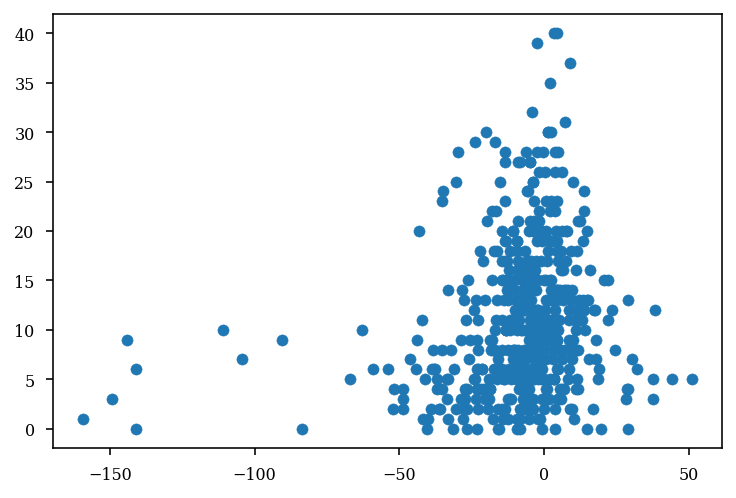

In [338]:
plt.scatter(df_hmc1.effective, df_hmc1.pfc_spikes)


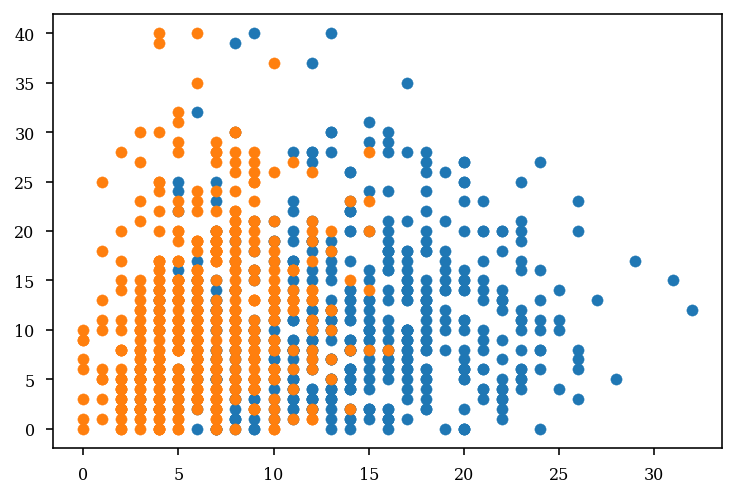

In [336]:
plt.scatter(df_hmc1.n_deep_obs, df_hmc1.pfc_spikes)
plt.scatter(df_hmc1.n_sup_obs, df_hmc1.pfc_spikes)


In [344]:
X_train.shape, X_test.shape


((382, 2), (128, 2))

-0.13105611668304318


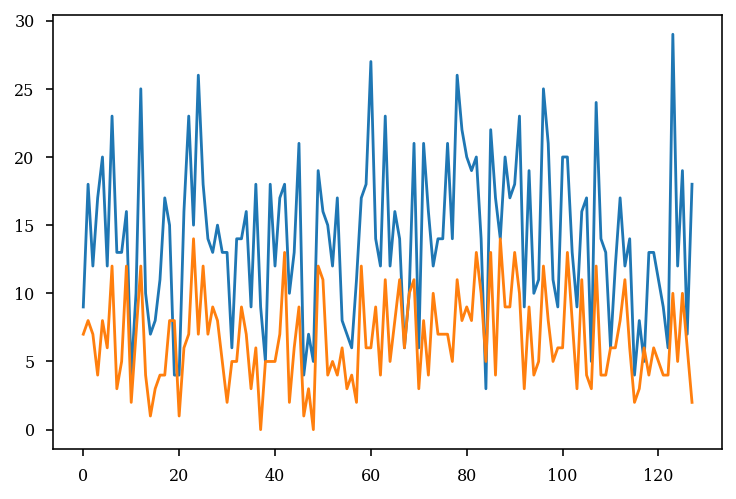

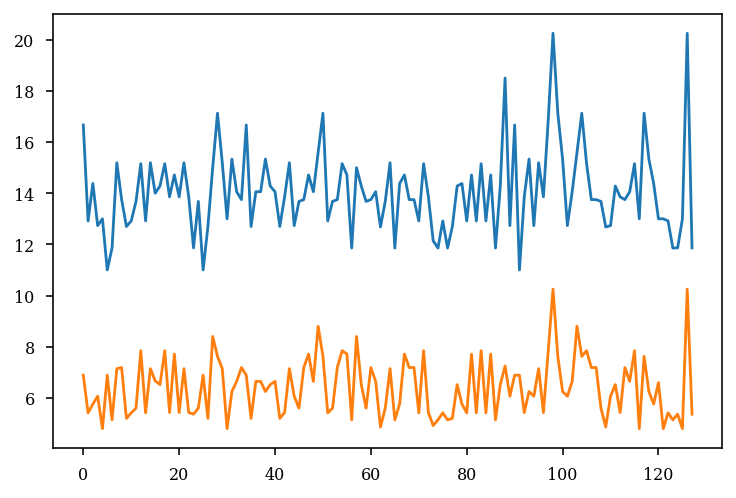

In [349]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

y = df_hmc1[["n_deep_obs", "n_sup_obs"]].values
X = np.vstack([np.ones_like(df_hmc1.pfc_spikes.values), df_hmc1.pfc_spikes.values]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

print(reg.score(X_test, y_test))

plt.plot(y_test)
plt.show()
plt.plot(reg.predict(X_test))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

y = df_hmc1[["n_deep_obs", "n_sup_obs"]].values
X = np.vstack([np.ones_like(df_hmc1.pfc_spikes.values), df_hmc1.pfc_spikes.values]).T

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

print(reg.score(X_test, y_test))

plt.plot(y_test)
plt.show()
plt.plot(reg.predict(X_test))

accuracy_score(y_test[:, 0], reg.predict(X_test)[:, 0])


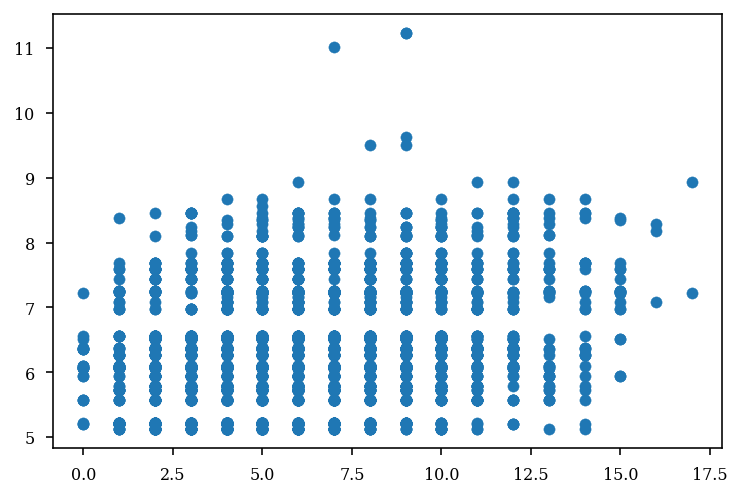

In [370]:
plt.scatter(y_test[:, 1], reg.predict(X_test)[:, 1])


([], [])

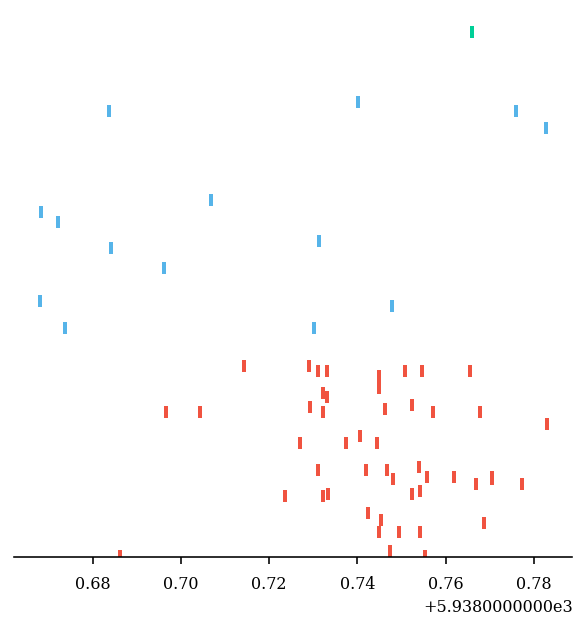

In [278]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

rip = 8
npl.rasterplot(
    st[:, ca1_idx][replays_epochs[rip]],
    lw=2,
    lh=5,
    ax=ax,
    color=npl.colors.sweet.red,
    vertstack=True,
)
npl.rasterplot(
    st[:, pfc_idx][replays_epochs[rip]],
    lw=2,
    lh=5,
    ax=ax,
    color=npl.colors.sweet.blue,
    vertstack=True,
)
npl.rasterplot(
    st[:, mec_idx][replays_epochs[rip]],
    lw=2,
    lh=5,
    ax=ax,
    color=npl.colors.sweet.green,
    vertstack=True,
)
sns.despine(left=True)
plt.yticks([])


In [265]:
psth_z.shape[1]


106

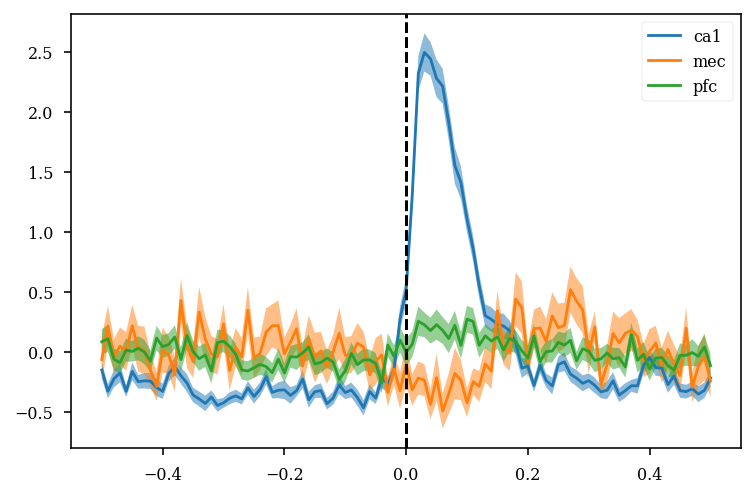

In [269]:
def plot_psth_mean(st, replays_epochs, region_idx, label):

    psth = functions.compute_psth(
        st[:, region_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100
    )
    psth_z = stats.zscore(psth, axis=0)
    plt.plot(np.mean(psth_z, axis=1), label=label)
    plt.fill_between(
        psth.index,
        np.mean(psth_z, axis=1) - np.std(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        np.mean(psth_z, axis=1) + np.std(psth_z, axis=1) / np.sqrt(psth.shape[1]),
        alpha=0.5,
    )
    plt.axvline(x=0, color="k", linestyle="--")
    plt.legend()


plot_psth_mean(st, replays_epochs, ca1_idx, label="ca1")
plot_psth_mean(st, replays_epochs, mec_idx, label="mec")
plot_psth_mean(st, replays_epochs, pfc_idx, label="pfc")


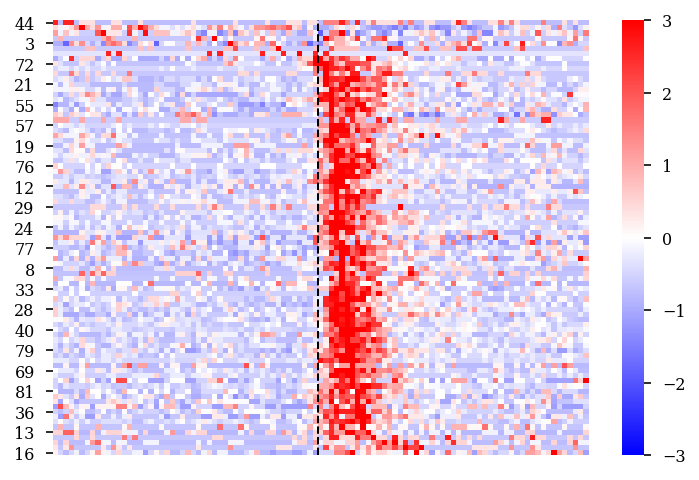

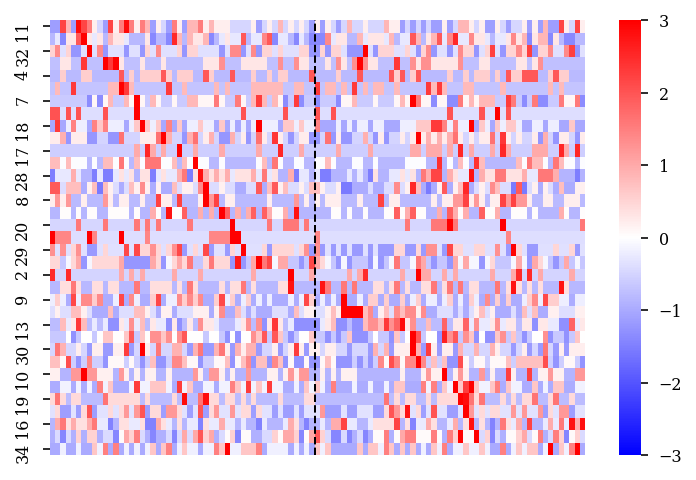

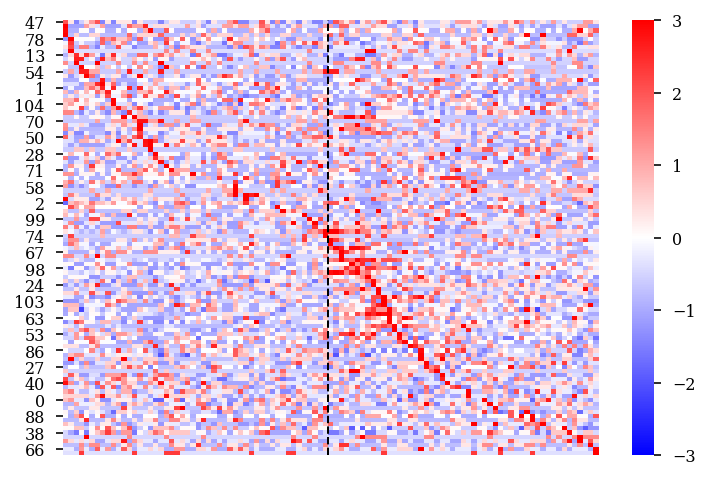

In [263]:
psth = functions.compute_psth(
    st[:, ca1_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100
)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values, axis=0))
sns.heatmap(
    stats.zscore(psth, axis=0)[sort_idx].T,
    ax=ax,
    cmap="bwr",
    vmax=3,
    vmin=-3,
    xticklabels=False,
)
ax.axvline(50, color="k", lw=1, ls="--")

psth = functions.compute_psth(
    st[:, mec_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100
)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values, axis=0))
sns.heatmap(
    stats.zscore(psth, axis=0)[sort_idx].T,
    ax=ax,
    cmap="bwr",
    vmax=3,
    vmin=-3,
    xticklabels=False,
)
ax.axvline(50, color="k", lw=1, ls="--")

psth = functions.compute_psth(
    st[:, pfc_idx].data, replays_epochs.starts, bin_width=0.01, n_bins=100
)
plt.figure()
ax = plt.gca()
sort_idx = np.argsort(np.argmax(psth.values, axis=0))
sns.heatmap(
    stats.zscore(psth, axis=0)[sort_idx].T,
    ax=ax,
    cmap="bwr",
    vmax=3,
    vmin=-3,
    xticklabels=False,
)
ax.axvline(50, color="k", lw=1, ls="--")


In [155]:
bin_width = 0.01
n_bins = 100
times = np.linspace(-(n_bins * bin_width) / 2, (n_bins * bin_width) / 2, n_bins + 1)
times
# np.where(times == 0)
# (times - times.min())[times == 0]


array([-0.5 , -0.49, -0.48, -0.47, -0.46, -0.45, -0.44, -0.43, -0.42,
       -0.41, -0.4 , -0.39, -0.38, -0.37, -0.36, -0.35, -0.34, -0.33,
       -0.32, -0.31, -0.3 , -0.29, -0.28, -0.27, -0.26, -0.25, -0.24,
       -0.23, -0.22, -0.21, -0.2 , -0.19, -0.18, -0.17, -0.16, -0.15,
       -0.14, -0.13, -0.12, -0.11, -0.1 , -0.09, -0.08, -0.07, -0.06,
       -0.05, -0.04, -0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,
        0.04,  0.05,  0.06,  0.07,  0.08,  0.09,  0.1 ,  0.11,  0.12,
        0.13,  0.14,  0.15,  0.16,  0.17,  0.18,  0.19,  0.2 ,  0.21,
        0.22,  0.23,  0.24,  0.25,  0.26,  0.27,  0.28,  0.29,  0.3 ,
        0.31,  0.32,  0.33,  0.34,  0.35,  0.36,  0.37,  0.38,  0.39,
        0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,
        0.49,  0.5 ])

In [26]:
import neo
import numpy as np
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process
from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import covariance


In [27]:
np.random.seed(1)
st1 = homogeneous_poisson_process(rate=10 * pq.Hz, t_stop=10.0 * pq.s)
st2 = homogeneous_poisson_process(rate=10 * pq.Hz, t_stop=10.0 * pq.s)
cov_matrix = covariance(BinnedSpikeTrain([st1, st2], bin_size=5 * pq.ms))
cov_matrix


array([[ 0.05432316, -0.00152276],
       [-0.00152276,  0.04917234]])

In [31]:
st1.times


array([0.05396058, 0.18137311, 0.18138455, 0.21738582, 0.23325678,
       0.24294517, 0.26355663, 0.30595428, 0.35649954, 0.43389551,
       0.48822945, 0.60381742, 0.62668986, 0.83715959, 0.83993655,
       0.95094459, 1.00495369, 1.08675442, 1.10188171, 1.12395904,
       1.28527581, 1.63029853, 1.66790239, 1.78577274, 1.99483444,
       2.21984002, 2.22872798, 2.23271176, 2.25132429, 2.46181459,
       2.47216712, 2.52683099, 2.84357688, 2.91975488, 3.03748054,
       3.07538949, 3.19138538, 3.37133975, 3.37318551, 3.51187269,
       3.96160377, 4.09950214, 4.13241423, 4.28813642, 4.29903156,
       4.358433  , 4.59767906, 4.63243842, 4.66637461, 4.6803041 ,
       4.6822598 , 4.79583999, 4.81961853, 4.85048141, 4.9181248 ,
       4.92360871, 5.00896792, 5.02483567, 5.11382625, 5.23414301,
       5.24493878, 5.29839189, 5.41693976, 5.47041391, 5.47553834,
       5.55230309, 5.6613064 , 5.73364418, 6.02295228, 6.11127537,
       6.34499501, 6.35978409, 6.37478226, 6.53949172, 6.59018